In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from pymongo import MongoClient
import ystockquote

In [4]:
from datetime import datetime
import math

# Load transcripts

In [5]:
client = MongoClient('localhost', 27017)
earnings_transcript_collection = client.python_import.earnings_transcript

In [6]:
earnings_transcript = pd.DataFrame(list(earnings_transcript_collection.find({'tradingSymbol':'AAPL'})))
earnings_transcript.drop('_id', axis=1, inplace=True)

In [7]:
earnings_transcript['publishDate_str'] = earnings_transcript.apply(
    lambda row: str(datetime.strptime(row['publishDate'], '%Y-%m-%dT%H:%M:%SZ').date()), 
    axis=1)
earnings_transcript.head(1)

,publishDate,qAndAText,rawText,tradingSymbol,url,publishDate_str
0,2016-07-27T01:01:38Z,Operator Your first question will come from Sh...,"Apple, Inc. (NASDAQ: AAPL ) Q3 2016 Earnings C...",AAPL,https://seekingalpha.com/article/3991811-apple...,2016-07-27


In [8]:
earnings_transcript.set_index(['tradingSymbol', 'publishDate_str'], inplace=True)
earnings_transcript.head(2)

publishDate  \
tradingSymbol publishDate_str                         
AAPL          2016-07-27       2016-07-27T01:01:38Z   
              2012-10-26       2012-10-26T01:33:03Z   

                                                                       qAndAText  \
tradingSymbol publishDate_str                                                      
AAPL          2016-07-27       Operator Your first question will come from Sh...   
              2012-10-26       Operator (Operator Instructions) Your first qu...   

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
AAPL          2016-07-27       Apple, Inc. (NASDAQ: AAPL ) Q3 2016 Earnings C...   
              2012-10-26       Apple Inc. (NASDAQ: AAPL ) F4Q12 Earnings Call...   

                                                                             url  
tradingSymbol publishDate_str                                                     
AAPL          2016-07-27       https://seekingalpha.com/article/3991811-apple...  
              2012-10-26       https://seekingalpha.com/article/952971-apples...

In [9]:
earnings_transcript.tail(2)

publishDate  \
tradingSymbol publishDate_str                         
AAPL          2007-10-23       2007-10-23T00:30:44Z   
              2008-01-23       2008-01-23T02:17:14Z   

                                                                       qAndAText  \
tradingSymbol publishDate_str                                                      
AAPL          2007-10-23                                                           
              2008-01-23       Operator (Operator Instructions) Our first que...   

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
AAPL          2007-10-23       Apple Inc. (NASDAQ: AAPL ) F4Q07 Earnings Call...   
              2008-01-23       Apple Inc. (NASDAQ: AAPL ) F1Q08 Earnings Call...   

                                                                             url  
tradingSymbol publishDate_str                                                     
AAPL          2007-10-23       https://seekingalpha.com/article/50846-apple-f...  
              2008-01-23       https://seekingalpha.com/article/61117-apple-f...

### Load all ticker data for transcripts

In [10]:
earnings_transcript.index.levels[0]

Index(['AAPL'], dtype='object', name='tradingSymbol')

In [11]:
class Applyer:
    
    label = ''
    label_to_check_against = None
    
    @staticmethod
    def label_calc(row):
        
        val_to_check = 0
        if Applyer.label_to_check_against is not None:
            val_to_check = row[Applyer.label_to_check_against]
        
        if math.isnan(row[Applyer.label]) or math.isnan(val_to_check):
            return 0

        if abs(row[Applyer.label]) >= val_to_check:
            if row[Applyer.label] <= 0:
                return -1
            else:
                return 1
        else:
            return 0
    
    @staticmethod
    def all_label_calc(df):
        df['Std Dev'] = pd.Series(data=df['Close']).rolling(window=20,center=False).std()

        df['1day return'] = df['Close'].shift(-1) - df['Close']
        df['5day return'] = df['Close'].shift(-5) - df['Close']

        Applyer.label_to_check_against = None

        Applyer.label = '1day return'
        df['1day label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day label'] = df.apply(Applyer.label_calc, axis=1)

        Applyer.label_to_check_against = 'Std Dev'

        Applyer.label = '1day return'
        df['1day significant label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day significant label'] = df.apply(Applyer.label_calc, axis=1)

In [12]:
tickers = earnings_transcript.index.levels[0]
all_stocks = None
for ticker in tickers:
    stocks = ystockquote.get_historical_prices(ticker, '2000-01-01', '2017-12-31')
    print('{} ticker has {} long list'.format(ticker, len(stocks)))
    df = pd.DataFrame(stocks).transpose()
    if 'Adj Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Adj Close'], errors='ignore')
    elif 'Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Close'], errors='ignore')
    else:
        print('{} is not available'.format(ticker))
        continue
    df.drop(axis=1, labels=[col for col in df.columns if col not in ['Close']], inplace=True)
    indexes = pd.MultiIndex.from_product([[ticker], df.index.values.tolist()], names=['tradingSymbol', 'publishDate_str'])
    df.set_index(indexes, inplace=True)
    
    Applyer.all_label_calc(df)
    df.dropna(inplace=True)
    
    if all_stocks is None:
        all_stocks = df
    else:
        all_stocks = all_stocks.append(df)

AAPL ticker has 4340 long list


In [13]:
len(all_stocks)

4316

In [14]:
all_stocks.sample(20)

Close   Std Dev  1day return  5day return  \
tradingSymbol publishDate_str                                                   
AAPL          2009-07-08        17.778162  0.349223    -0.111422     1.251544   
              2016-09-02       106.717038  1.074390    -0.029724    -2.268468   
              2014-06-17        87.369207  2.292806     0.094883    -1.707915   
              2001-09-10         1.125225  0.031751    -0.024617    -0.106239   
              2008-10-29        13.545451  0.705335     0.840841    -0.161949   
              2000-07-19         3.413084  0.163354     0.157901    -0.170046   
              2011-02-17        46.421188  1.261757    -1.002790    -1.313733   
              2003-08-04         1.373979  0.036364    -0.053767    -0.100409   
              2012-12-17        67.816318  3.367331     1.969806     0.175152   
              2012-07-30        77.091821  1.445573     2.037969     3.565478   
              2013-09-27        64.309979  2.063974    -0.799300     0.037301   
              2006-06-02         7.988642  0.478237    -0.215069    -0.313534   
              2003-03-20         0.965867  0.016876     0.005830    -0.027208   
              2005-09-09         6.647700  0.200632     0.011661    -0.012955   
              2009-01-06        12.051629  0.675632    -0.260414    -0.687961   
              2015-04-30       120.328503  1.973581     3.653597     0.608827   
              2011-10-20        51.216187  2.088299    -0.316125     1.215269   
              2003-12-31         1.384344  0.036222    -0.005830     0.128912   
              2017-01-30       121.104937  1.927247    -0.278790     8.622612   
              2001-02-09         1.238913  0.097142     0.036439    -0.008097   

                               1day label  5day label  1day significant label  \
tradingSymbol publishDate_str                                                   
AAPL          2009-07-08               -1           1                       0   
              2016-09-02               -1          -1                       0   
              2014-06-17                1          -1                       0   
              2001-09-10               -1          -1                       0   
              2008-10-29                1          -1                       1   
              2000-07-19                1          -1                       0   
              2011-02-17               -1          -1                       0   
              2003-08-04               -1          -1                      -1   
              2012-12-17                1           1                       0   
              2012-07-30                1           1                       1   
              2013-09-27               -1           1                       0   
              2006-06-02               -1          -1                       0   
              2003-03-20                1          -1                       0   
              2005-09-09                1          -1                       0   
              2009-01-06               -1          -1                       0   
              2015-04-30                1           1                       1   
              2011-10-20               -1           1                       0   
              2003-12-31               -1           1                       0   
              2017-01-30               -1           1                       0   
              2001-02-09                1          -1                       0   

                               5day significant label  
tradingSymbol publishDate_str                          
AAPL          2009-07-08                            1  
              2016-09-02                           -1  
              2014-06-17                            0  
              2001-09-10                           -1  
              2008-10-29                            0  
              2000-07-19                           -1  
              2011-02-

# Merge transcripts with stock data

In [15]:
earnings_transcript = earnings_transcript.merge(all_stocks, left_index=True, right_index=True)

In [16]:
earnings_transcript.sample(5)

publishDate  \
tradingSymbol publishDate_str                         
AAPL          2011-10-19       2011-10-19T02:10:11Z   
              2014-07-23       2014-07-23T02:26:03Z   
              2006-07-20       2006-07-20T00:48:42Z   
              2006-10-19       2006-10-19T04:56:21Z   
              2009-07-21       2009-07-21T23:41:32Z   

                                                                       qAndAText  \
tradingSymbol publishDate_str                                                      
AAPL          2011-10-19       Operator From Goldman Sachs, we'll go to Bill ...   
              2014-07-23                                                           
              2006-07-20       Operator   Thank you.  (Operator Instructions)...   
              2006-10-19       Operator (Operator Instructions) We'll take ou...   
              2009-07-21       Operator (Operator Instructions) We’ll take ou...   

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
AAPL          2011-10-19       Apple (NASDAQ: AAPL ) Q4 2011 Earnings Call Oc...   
              2014-07-23       Apple Inc. (NASDAQ: AAPL ) Q3 2014 Earnings Co...   
              2006-07-20       Apple Computer, Inc. (NASDAQ: AAPL ) F3Q06 Ear...   
              2006-10-19       Apple Computer Inc. (NASDAQ: AAPL ) F4Q06 Earn...   
              2009-07-21       Apple Inc. (NASDAQ: AAPL ) F3Q09 Earnings Call...   

                                                                             url  \
tradingSymbol publishDate_str                                                      
AAPL          2011-10-19       https://seekingalpha.com/article/300433-apples...   
              2014-07-23       https://seekingalpha.com/article/2331715-apple...   
              2006-07-20       https://seekingalpha.com/article/13884-apple-f...   
              2006-10-19       https://seekingalpha.com/article/18756-apple-f...   
              2009-07-21       https://seekingalpha.com/article/150291-apple-...   

                                   Close   Std Dev  1day return  5day return  \
tradingSymbol publishDate_str                                                  
AAPL          2011-10-19       51.645027  2.096822    -0.428840     0.256530   
              2014-07-23       92.217781  1.658080    -0.151817     0.910886   
              2006-07-20        7.838353  0.360292     0.028503     0.375723   
              2006-10-19       10.233909  0.195203     0.124377     0.414590   
              2009-07-21       19.629567  0.720489     0.677596     1.099962   

                               1day label  5day label  1day significant label  \
tradingSymbol publishDate_str                                                   
AAPL          2011-10-19               -1           1                       0   
              2014-07-23               -1           1                       0   
              2006-07-20                1           1                       0   
              2006-10-19                1           1                       0   
              2009-07-21                1           1                       0   

                               5day significant label  
tradingSymbol publishDate_str                          
AAPL          2011-10-19                            0  
              2014-07-23                            0  
              2006-07-20                            1  
              2006-10-19                            1  
              2009-07-21                            1

In [17]:
shorts = earnings_transcript[earnings_transcript['rawText'].apply(len) < 5000]

In [18]:
len(shorts)

0

In [19]:
earnings_transcript = earnings_transcript[earnings_transcript['rawText'].apply(len) > 5000]

# Create train data and test data

In [20]:
X = earnings_transcript['rawText']
y = earnings_transcript['5day significant label']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Tf-Idf and LogisticRegression model

In [32]:
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words='english', max_df=0.1, min_df=1, ngram_range=(1,3))),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('model', MultinomialNB())
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        s...ear_tf=False, use_idf=True)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [33]:
y_predicted = pipeline.predict(X_test)

#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [34]:
cm = confusion_matrix(y_test, y_predicted)

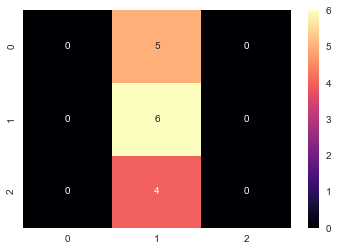

In [35]:
sns.heatmap(cm, cmap='magma', annot=True)

In [36]:
cr = classification_report(y_test, y_predicted)
print(cr)

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         5
          0       0.40      1.00      0.57         6
          1       0.00      0.00      0.00         4

avg / total       0.16      0.40      0.23        15



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
